# Mentoria

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io
import chardet
from unidecode import unidecode

# detect the laguage of the text in the field mesaage_text
from langdetect import detect, detect_langs
from langdetect.lang_detect_exception import LangDetectException



sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

In [143]:
src_ds = "data/dataset_diplodatos_completo.csv"
df = pd.read_csv(src_ds)
df.info()

# Original total: 149859

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149859 entries, 0 to 149858
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     149859 non-null  int64  
 1   commodity              119269 non-null  object 
 2   source_posted_at       149859 non-null  object 
 3   trade_type             140916 non-null  object 
 4   chat_id                25857 non-null   float64
 5   telegram_user_id       25857 non-null   float64
 6   message_text           149859 non-null  object 
 7   date_source_posted_at  149859 non-null  object 
 8   message_text_clean     149859 non-null  object 
 9   message_length         149859 non-null  int64  
 10  message_lbr            149859 non-null  int64  
 11  language               149859 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 13.7+ MB


In [144]:
def clean_lbr(text):
    # Replace continuous line breaks with a single line break
    cleaned_text = '\n'.join(line.strip() for line in text.splitlines() if line.strip())
    return cleaned_text

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def count_line_breaks(text):
    return text.count('\n')

## Limpieza de datos y enriquecimiento
- Sacar los emojis
- Identificar idiomas
    - Adicionar una columna y guardar el dataset
    - Actualizar solo si no existe o se fuerza

- Trim multiple lbrs to ones
- Adicionar message_lbrs
- Adicionar message_length
- Adicionar comodity_in_msg - Pending
- fix date format



In [145]:
force_process = True

if 'message_length' not in df.columns or force_process :
    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # Trim and remove multiple line breaks
    df['message_text_clean'] = df['message_text'].apply(clean_lbr)

    # Eliminar emojis y añadir columna message_no_emoji
    df['message_text_clean'] = df['message_text_clean'].apply(remove_emojis).str.strip().str.lower()

    # Añadir columna con la longitud del mensaje sin emojis
    df['message_length'] = df['message_text_clean'].str.len()

    # Añadir columna con el número de saltos de línea
    df['message_lbr'] = df['message_text_clean'].apply(count_line_breaks)


    # # Detect the encoding of messages in the field message_text_clean of type string\
    df['message_encoding'] = df['message_text_clean'].apply(lambda x: chardet.detect(x.encode())['encoding'])

    
    df['message_text_clean_utf8'] = df['message_text_clean']

    # # convert the all the messages to utf-8 where the encoding is different form utf-8
    flt = df['message_encoding'] != 'utf-8'
    df.loc[flt, 'message_text_clean_utf8'] = df[flt]['message_text_clean'].apply(lambda x: unidecode(x))

    df['message_encoding2'] = df['message_text_clean_utf8'].apply(lambda x: chardet.detect(x.encode())['encoding'])


In [146]:

url = "https://www.unicode.org/Public/security/15.0.0/confusables.txt"
confusables_df = pd.read_csv(url, sep=';', comment='#', header=None, names=['src', 'dst', 'extra'])
confusables_df['src'] = confusables_df['src'].str.strip()
confusables_df['dst'] = confusables_df['dst'].str.strip()

confusables_df = confusables_df[~confusables_df['dst'].str.contains(' ')]
confusables_df["src_char"] = confusables_df["src"].apply(lambda x: chr(int(x, 16)))
confusables_df["dst_char"] = confusables_df["dst"].apply(lambda x: chr(int((x.replace('\t', '')), 16)))

confusables_df['src_enc'] = confusables_df["src"].apply(lambda x: chardet.detect(x.encode())['encoding'])

# exluding the characters that are in utf-8 encoding and ascii encoding
confusables_df = confusables_df[~confusables_df['src_enc'].isin(['utf-8', 'ascii'])]

# export the confusables_df to a python dictionary
confusables_dict = confusables_df.set_index('src_char')['dst_char'].to_dict()



In [147]:
# filter congusables by dst_char = | 
# kk = confusables_df[confusables_df['dst_char'] == 'l']
kk = confusables_df[confusables_df['src_char'] == '1']

# print all rows from the filtered dataframe one by one
for index, row in kk.iterrows():
    enc = chardet.detect(row['src_char'].encode())['encoding']
    enc_dst = chardet.detect(row['dst_char'].encode())['encoding']
    # if enc == 'utf-8' or enc == 'ascii' or enc is None or enc == 'None':  
    #     print(row['src_char'], row['dst_char'], enc, enc_dst)
    print(row['src_char'], row['dst_char'], enc, enc_dst)


In [148]:
def replace_confusables(text):
    return ''.join(confusables_dict.get(char, char) for char in text)

# apply the replace_confusables function to the message_text_clean_utf8 column
df['message_text_clean_utf8_cf'] = df['message_text_clean_utf8'].apply(replace_confusables)


In [149]:
# count the number of messages per encoding
print(df['message_encoding'].value_counts())
print(df['message_encoding2'].value_counts())

message_encoding
ascii           130748
utf-8             8208
Windows-1254      5666
Windows-1252      3735
ISO-8859-1        1123
                 ...  
Johab                5
EUC-JP               4
windows-1253         1
TIS-620              1
GB2312               1
Name: count, Length: 12, dtype: int64
message_encoding2
ascii    141651
utf-8      8208
Name: count, dtype: int64


In [150]:
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException as e:
        print(e, text) 
        return "Unknown"
    else:
        print(e, text)
        return "Error langdetect"

def detect_multiple_languages(text):
    try:
        return detect_langs(text)
    except LangDetectException as e:
        print(e, text) 
        return "Unknown"
    else:
        print(e, text)
        return "Error langdetect"

In [151]:
from pandarallel import pandarallel
pandarallel.initialize()

# df = df.head(10)
if 'language' not in df.columns:
    # df['language'] = df['message_text'].apply(lambda x: detect_language(x) if x is not None else None)
    # df['language'] = df['message_text'].apply(lambda x: detect_language(x) if x is not None else None)
    df['language'] = df['message_text_clean'].parallel_apply(detect_language)
    df.to_csv(src_ds, index=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [152]:
df.head(10)

,id,commodity,source_posted_at,trade_type,chat_id,telegram_user_id,message_text,date_source_posted_at,message_text_clean,message_length,message_lbr,language,message_encoding,message_text_clean_utf8,message_encoding2,message_text_clean_utf8_cf
0,2001,DOGE,2022-10-29 17:45:19+00,sell,NaN,NaN,ByBit USDT\n#DOGE/USDT Cancelled ❌\nTarget ach...,2022-10-29 17:45:19+00:00,bybit usdt\n#doge/usdt cancelled \ntarget achi...,79,2,en,ascii,bybit usdt\n#doge/usdt cancelled \ntarget achi...,ascii,bybit usdt\n#doge/usdt cancelled \ntarget achi...
1,45874,REN,2022-01-15 13:01:43+00,buy,NaN,NaN,"ByBit USDT, Binance Futures\n#REN/USDT Entry t...",2022-01-15 13:01:43+00:00,"bybit usdt, binance futures\n#ren/usdt entry t...",81,2,en,ascii,"bybit usdt, binance futures\n#ren/usdt entry t...",ascii,"bybit usdt, binance futures\n#ren/usdt entry t..."
2,49325,ATA,2022-01-14 21:03:16+00,sell,NaN,NaN,Binance Futures\n#ATA/USDT Take-Profit target ...,2022-01-14 21:03:16+00:00,binance futures\n#ata/usdt take-profit target ...,93,3,en,ascii,binance futures\n#ata/usdt take-profit target ...,ascii,binance futures\n#ata/usdt take-profit target ...
3,116487,CLV,2022-08-05 09:32:48+00,sell,NaN,NaN,#CLV here is like a bird out of cage after a l...,2022-08-05 09:32:48+00:00,#clv here is like a bird out of cage after a l...,114,1,en,Windows-1252,#clv here is like a bird out of cage after a l...,ascii,#clv here is like a bird out of cage after a l...
4,468132,SOL,2022-04-03 02:20:32+00,buy,25.0,850186.0,TF-V: 5M30S-LLTF-V4\nACCURACY: 91%\nBUY/LONG\n...,2022-04-03 02:20:32+00:00,tf-v: 5m30s-lltf-v4\naccuracy: 91%\nbuy/long\n...,171,12,en,ascii,tf-v: 5m30s-lltf-v4\naccuracy: 91%\nbuy/long\n...,ascii,tf-v: 5m30s-lltf-v4\naccuracy: 91%\nbuy/long\n...
5,33787,VET,2022-06-14 02:05:13+00,sell,NaN,NaN,"ByBit USDT, Binance Futures\n#VET/USDT All tak...",2022-06-14 02:05:13+00:00,"bybit usdt, binance futures\n#vet/usdt all tak...",117,3,en,ascii,"bybit usdt, binance futures\n#vet/usdt all tak...",ascii,"bybit usdt, binance futures\n#vet/usdt all tak..."
6,116491,VITE,2022-08-07 16:36:22+00,buy,NaN,NaN,We are buying #VITE here\n\nVITE is ready for ...,2022-08-07 16:36:22+00:00,we are buying #vite here\nvite is ready for a ...,157,2,en,ascii,we are buying #vite here\nvite is ready for a ...,ascii,we are buying #vite here\nvite is ready for a ...
7,51223,DOGE,2022-01-24 18:13:34+00,sell,NaN,NaN,ByBit USDT\n#DOGE/USDT Take-Profit target 2 ✅\...,2022-01-24 18:13:34+00:00,bybit usdt\n#doge/usdt take-profit target 2 \n...,88,3,en,ascii,bybit usdt\n#doge/usdt take-profit target 2 \n...,ascii,bybit usdt\n#doge/usdt take-profit target 2 \n...
8,51225,BAND,2022-01-24 18:14:55+00,sell,NaN,NaN,Binance Futures\n#BAND/USDT Take-Profit target...,2022-01-24 18:14:55+00:00,binance futures\n#band/usdt take-profit target...,93,3,en,ascii,binance futures\n#band/usdt take-profit target...,ascii,binance futures\n#band/usdt take-profit target...
9,51226,DYDX,2022-01-24 18:15:47+00,sell,NaN,NaN,"Binance Futures, ByBit USDT\n#DYDX/USDT Take-P...",2022-01-24 18:15:47+00:00,"binance futures, bybit usdt\n#dydx/usdt take-p...",104,3,en,ascii,"binance futures, bybit usdt\n#dydx/usdt take-p...",ascii,"binance futures, bybit usdt\n#dydx/usdt take-p..."


In [153]:
# filter df by languages with length > 2
pd.set_option('display.max_rows', 18)
filter = df['language'].str.len() >2
df[filter][['language', 'message_text_clean']]
# configure jupyter to show 18 rows 




,language,message_text_clean
7820,Unknown,https://www.theblockcrypto.com/post/135459/eur...
86223,Unknown,+40%\nhttps://www.tradingview.com/x/epumlmd4/
97465,Unknown,+36%
120063,Unknown,https://www.theblock.co/post/162913/ethereums-...
123292,Unknown,https://thehiddenwiki.com/new-long-v3-onion-se...
132886,Unknown,𝗣𝗿𝗼𝗳𝗲𝘀𝘀𝗶𝗼𝗻𝗮𝗹 𝗠𝗮𝗿𝗸𝗲𝘁𝗶𝗻𝗴\n𝗣𝗿𝗼𝗺𝗼𝘁𝗲 𝘆𝗼𝘂𝗿 𝗽𝗿𝗼𝗷𝗲𝗰𝘁\n...
135593,Unknown,https://m.economictimes.com/industry/services/...
135973,Unknown,https://www.tradingview.com/chart/btcusdt/acci...
136095,Unknown,https://www.tradingview.com/chart/ethusdt/7ppq...
136096,Unknown,https://www.tradingview.com/chart/btcusdt/beaf...


In [154]:
# Filter messages in english and Unknown
filter = df['language'].isin(['en', 'Unknown'])
df_filtered = df[filter]
df_filtered.info()



<class 'pandas.core.frame.DataFrame'>
Index: 125830 entries, 0 to 149858
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   id                          125830 non-null  int64              
 1   commodity                   105098 non-null  object             
 2   source_posted_at            125830 non-null  object             
 3   trade_type                  123512 non-null  object             
 4   chat_id                     17889 non-null   float64            
 5   telegram_user_id            17889 non-null   float64            
 6   message_text                125830 non-null  object             
 7   date_source_posted_at       125830 non-null  datetime64[ns, UTC]
 8   message_text_clean          125830 non-null  object             
 9   message_length              125830 non-null  int64              
 10  message_lbr                 125830 non-null  int6

In [155]:
# count the number of messages per encoding
df_filtered['message_encoding'].value_counts()


message_encoding
ascii           113923
utf-8             4149
Windows-1252      3717
Windows-1254      2753
ISO-8859-1         965
ISO-8859-9         296
MacRoman            16
Johab                5
EUC-JP               4
windows-1253         1
GB2312               1
Name: count, dtype: int64

In [156]:
# count null values on field chat_id
df_filtered['chat_id'].isnull().sum()

# give the percentage of null values on field chat_id
df_filtered['chat_id'].isnull().sum() / len(df_filtered) * 100


85.7831995549551

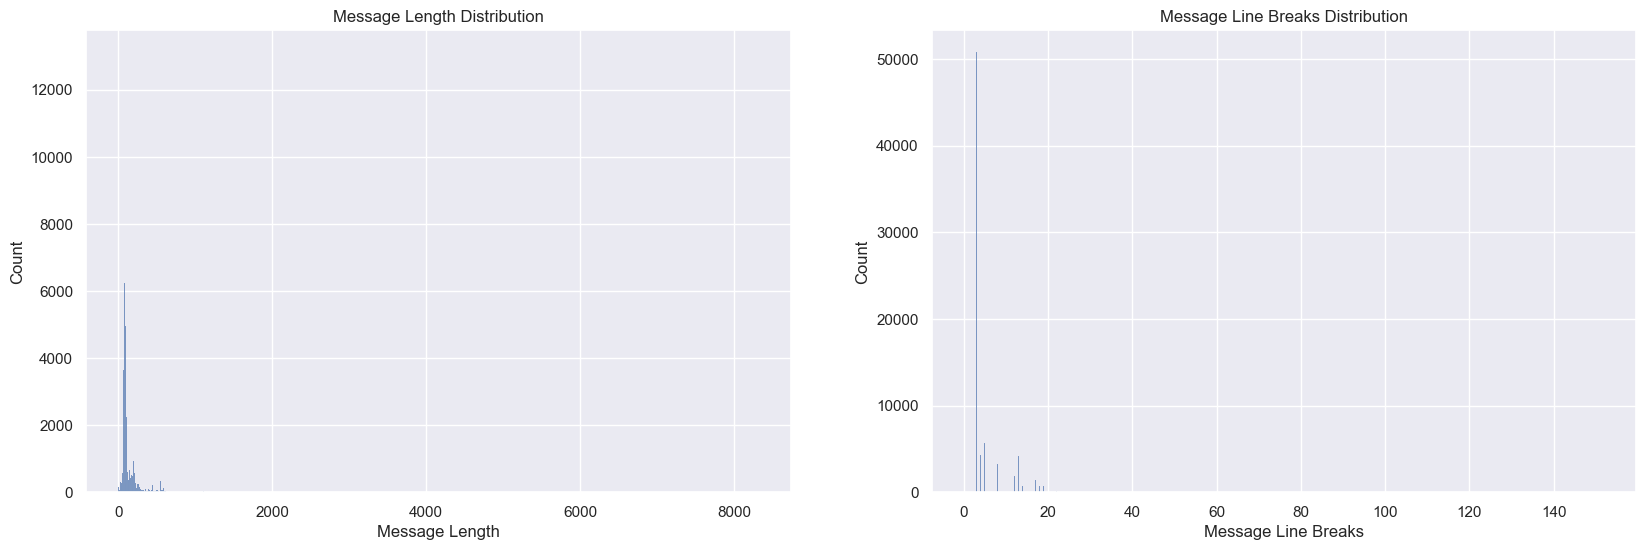

In [157]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
sns.histplot(data=df_filtered, x='message_length', ax=axs[0])
axs[0].set_title('Message Length Distribution')
axs[0].set_xlabel('Message Length')
axs[0].set_ylabel('Count')

sns.histplot(data=df_filtered, x='message_lbr', ax=axs[1])
axs[1].set_title('Message Line Breaks Distribution')
axs[1].set_xlabel('Message Line Breaks')
axs[1].set_ylabel('Count')

plt.show()



Hay outlier tanto para message length como para line breaks.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado.

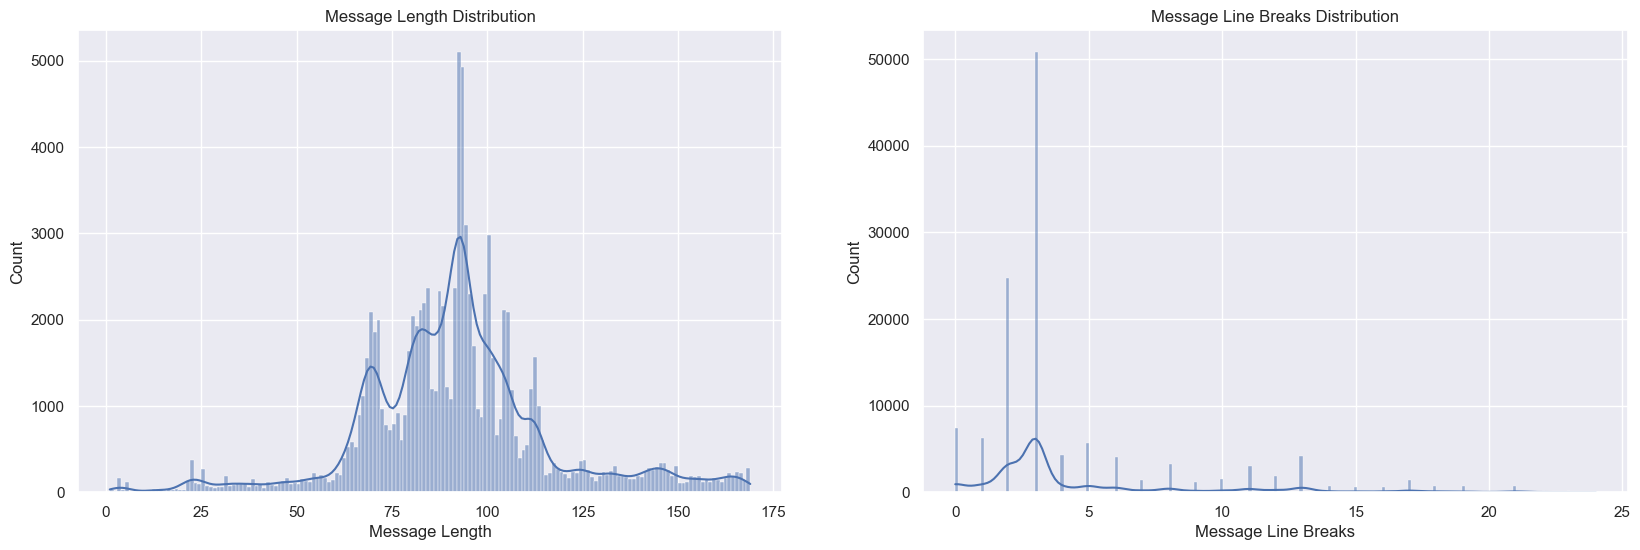

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
flt = df_filtered['message_length'] < 170
sns.histplot(data=df_filtered[flt], x='message_length', ax=axs[0], kde=True)
# sns.histplot(df_filtered[flt]['message_length'], bins=100, kde=True)
axs[0].set_title('Message Length Distribution')
axs[0].set_xlabel('Message Length')
axs[0].set_ylabel('Count')

flt = df_filtered['message_lbr'] < 25
sns.histplot(data=df_filtered[flt], x='message_lbr', ax=axs[1], kde=True)
# sns.histplot(['message_lbr'], bins=100, kde=True)
axs[1].set_title('Message Line Breaks Distribution')
axs[1].set_xlabel('Message Line Breaks')
axs[1].set_ylabel('Count')

plt.show()


Total filtered: 97303, 64.93%


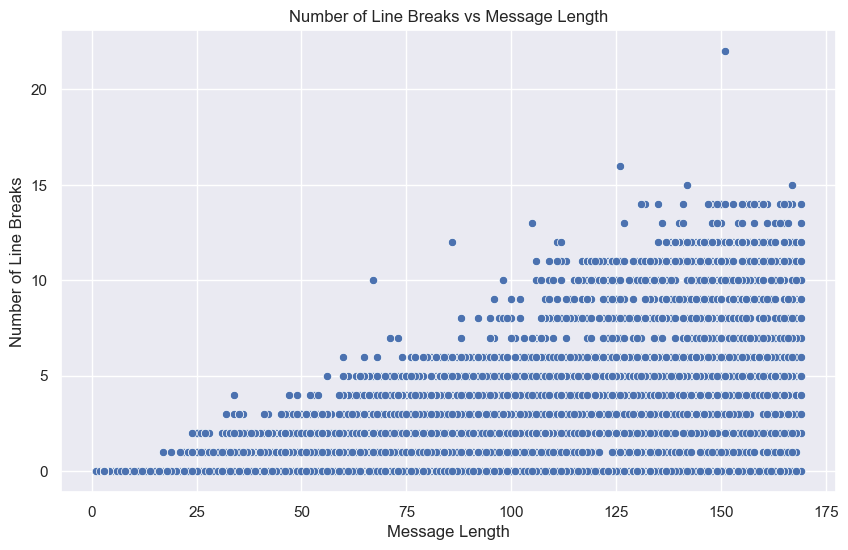

In [159]:
# Generate a distribution plot of the number of line breaks cross message length (scatter plot)
# flt = df['message_length'] < 3170
flt = (df_filtered['message_lbr'] < 25) & (df_filtered['message_length'] < 170)
total_filtered = len(df_filtered[flt])
print(f"Total filtered: {total_filtered}, {total_filtered/len(df):.2%}")

sns.scatterplot(data=df_filtered[flt], x='message_length', y='message_lbr')
plt.xlabel('Message Length')
plt.ylabel('Number of Line Breaks')
plt.title('Number of Line Breaks vs Message Length')
plt.show()


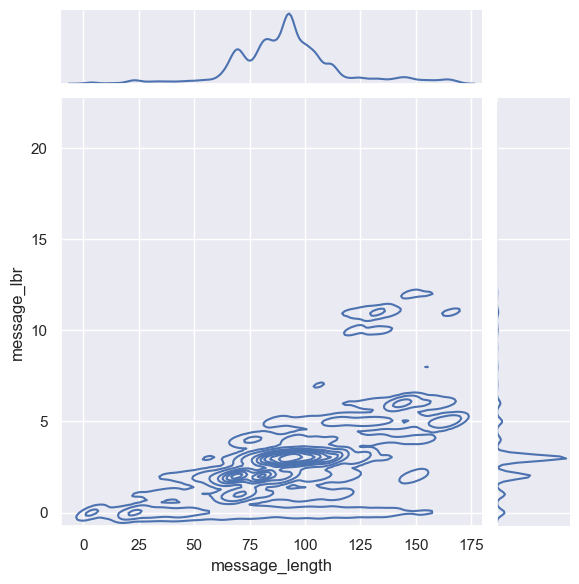

In [160]:
# TODO: Understand KDE plot and how to use it
g = sns.jointplot(data=df_filtered[flt], x='message_length', y='message_lbr', kind='kde')
plt.show()

In [161]:
# Look for possible tokes.
# message_field = "message_text_clean"
message_field = "message_text_clean_utf8_cf"
# generate a new dataframe that has each line of the messages as a row and keep the index of the original message
df_messages = df_filtered[message_field].str.split('\n').explode().reset_index()

# add a column with the length of each message
df_messages['message_length'] = df_messages[message_field].str.len()


# split the messages by : and add a column with the first part of the message
flt = df_messages[message_field].str.contains(':')
df_messages['message_text_clean_split'] = df_messages[flt][message_field].str.split(':').str[0].str.strip().str.lower()



In [162]:
# Get the list of tokens message_text_clean_split and the count as a dataframe
tokens = df_messages['message_text_clean_split'].value_counts()
tokens = tokens.reset_index()
tokens.columns = ['token', 'count']

# filter tokens with count > 2
flt = (tokens['count'] > 50)

print(tokens[flt].describe())

#print the tokens descending by count
print(tokens[flt])

# # sum of count
# tokens[flt]['count'].sum()

#export the tokens to a csv file on data folder, sorted by token
token_file = 'data/tokens3.csv'
tokens[flt].sort_values('token').to_csv(token_file, index=False, sep='|')


              count
count    148.000000
mean    1791.047297
std     6095.299984
min       52.000000
25%       84.250000
50%      269.500000
75%     1012.500000
max    49725.000000
                                                 token  count
0                                               period  49725
1                                               profit  49317
2                                  average entry price  16541
3                                             leverage  14392
4                                                https  11455
..                                                 ...    ...
143                                            revenue     56
144                                              price     55
145  remember our pump instructions and remember th...     54
146                                        entry range     54
147                                                  6     52

[148 rows x 2 columns]


In [163]:
token_mappping = [
["#coin", "coin"],
["#duration", "duration"],
["#period", "period"],
["#profit", "profit"],
["accuracy", "accuracy"],
["accuracy is", "accuracy"],
["advantage", "advantage"],
["amount", "amount"],
["average entry price", "average-entry-price"],
["buy", "buy"],
["buy range", "buy-zone"],
["buy zone", "buy-zone"],
["caption", "Rev"],
["coin", "coin"],
["coin is", "coin"],
["coin name", "coin"],
["country", "Rev"],
["current high", "current-high"],
["date", "Rev"],
["deposit", "Rev"],
["direction", "Rev"],
["duration", "duration"],
["entries", "entry"],
["entry", "entry"],
["entry 1", "entry-n"],
["entry 2", "entry-n"],
["entry below", "entry"],
["entry price", "entry-price"],
["entry range", "entry-range"],
["entry target", "entry-target"],
["entry targets", "entry-target"],
["entry targts", "entry-target"],
["entry zone", "entry-zone"],
["exchange", "exchange"],
["exchanges", "exchange"],
["exhange", "exchange"],
["leverage", "leverage"],
["long", "long"],
["long below", "long"],
["lower limit", "lower-limit"],
["manual stop", "manual-stop"],
["margin", "margin"],
["mark price", "mark-price"],
["max leverage", "max-leverage"],
["mid term targets", "mid-term-targets"],
["pair", "Rev"],
["pairing", "Rev"],
["payment _method", "payment-method"],
["period", "period"],
["plan", "Rev"],
["platform", "platform"],
["price", "price"],
["profit", "profit"],
["profit by signal", "profit"],
["profit targets", "profit"],
["revenue", "revenue"],
["sell", "sell"],
["short", "short"],
["short above", "?"],
["short term targets", "short-term-targets"],
["signal type", "signal-type"],
["sl", "sl-rev"],
["start price", "st-price"],
["starting", "starting?"],
["stop", "stop"],
["stop loss", "stop-loss"],
["stop target", "stop-target"],
["stop targets", "stop-target"],
["stop-loss", "stop-loss"],
["stop-loss orders", "stop-loss"],
["stoploss", "stop-loss"],
["take profit", "take-profit"],
["take profit 1", "take-profit-n"],
["take profit 2", "take-profit-n"],
["take profit 3", "take-profit-n"],
["take profit 4", "take-profit-n"],
["take profit 5", "take-profit-n"],
["take profit targets", "take-profit"],
["take-profit orders", "take-profit"],
["take-profit targets", "take-profit"],
["target", "target"],
["target 1", "target-n"],
["target 2", "target-n"],
["target 3", "target-n"],
["target 4", "target-n"],
["target 5", "target-n"],
["target 6", "target-n"],
["target 7", "target-n"],
["target 8", "target-n"],
["targets", "target"],
["targets achieved", "Rev"],
["targets usdt", "target?"],
["tf-v", "?"],
["ticker", "ticker"],
["time", "time?"],
["total profit", "total-profit"],
["tp", "tp"],
["tp1", "tpn"],
["tp2", "tpn"],
["tp3", "tpn"],
["tp4", "tpn"],
["tp5", "tpn"],
["tp6", "tpn"],
["trade type", "trade-type"],
["trading pair", "trading-pair"],
["trailing configuration", "Rev"],
["trigger", "trigger"],
["type", "type"],
["up zones", "Rev"],
["upper limit", "upper-limit"],
["ехсhanges", "ехсhange"],
]

In [164]:
import re

# generate a dataframe from token_mapping
df_token_mapping = pd.DataFrame(token_mappping, columns=['token_src', 'token'])

# add curly braces to the token
df_token_mapping['token'] = '{{' + df_token_mapping['token'] + '}}'



# add token length
df_token_mapping['token_src_length'] = df_token_mapping['token_src'].str.len()

# sort df_token_mapping by token_mapping and then length of token in descending order
df_token_mapping = df_token_mapping.sort_values(['token', 'token_src_length'], ascending=[True, False])

token_mapping = df_token_mapping[['token_src', 'token']].values.tolist()

base_patterns = [
    (r'\d{4}-\d{2}-\d{2}', '{{DATE}}'),
    (r'\d+\.\d+', '{{DECIMAL}}'),
    (r'\d+', '{{NUMBER}}'),
    (r'\$', '{{DOLLAR}}'),
    (r'[a-zA-Z]+', '{{WORD}}'),
    # (r'\w+', 'WORD'),
]

# add the base_patterns to the token_mapping
patterns = token_mapping + base_patterns

input_string = """tp1 tp 123 2021-10-10  $
123.45 hello tp take profit  target target 1
take profit tp2
take profit 1 take profit 2 tp1 tp2
"""



def process_chunk(chunk, patterns):
    for pattern in patterns:
        new_chunk = re.sub(pattern[0], pattern[1], chunk)
        if new_chunk != chunk:
            # reprocess the new_chunk
            return process_line(new_chunk, patterns)
    return chunk

def process_line(line, patterns):
    pattern_token = r'(\{\{.*?\}\})'
    parts = re.split(pattern_token, line)
    for i, part in enumerate(parts):
        if not re.match(pattern_token, part):
            parts[i] = process_chunk(part, patterns)
    return "".join(parts)

def simple_tokenizer2(text, patterns=patterns):
    lines = text.split('\n')
    processed_lines = [process_line(line, patterns) for line in lines]
    return '\n'.join(processed_lines)
    


In [165]:
msg_tpl = simple_tokenizer2(input_string, patterns) 
print(msg_tpl)

msg_tpl2 = simple_tokenizer2(input_string, token_mapping)
print(msg_tpl2)

{{tpn}} {{tp}} {{NUMBER}} {{DATE}}  {{DOLLAR}}
{{DECIMAL}} {{WORD}} {{tp}} {{WORD}} {{profit}}  {{target}} {{target-n}}
{{WORD}} {{profit}} {{tpn}}
{{WORD}} {{profit}} {{NUMBER}} {{WORD}} {{profit}} {{NUMBER}} {{tpn}} {{tpn}}

{{tpn}} {{tp}} 123 2021-10-10  $
123.45 hello {{tp}} take {{profit}}  {{target}} {{target-n}}
take {{profit}} {{tpn}}
take {{profit}} 1 take {{profit}} 2 {{tpn}} {{tpn}}



In [168]:
# how to apply a function with two params to a column and get the result in a new column
df_filtered['msg_tpl'] = df_filtered.parallel_apply(lambda x: simple_tokenizer2(x['message_text_clean_utf8_cf'], patterns), axis=1)



/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_82724/1864446330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['msg_tpl'] = df_filtered.parallel_apply(lambda x: simple_tokenizer2(x['message_text_clean_utf8_cf'], patterns), axis=1)


In [170]:
# add a field with a hash of the msg_tpl
df_filtered['msg_tpl_hash'] = df_filtered['msg_tpl'].apply(hash)


/var/folders/c1/5sw0mcxn0s5891c6173ck1sw0000gq/T/ipykernel_82724/113111668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['msg_tpl_hash'] = df_filtered['msg_tpl'].apply(hash)


In [ ]:
# count messages by msg_tpl
msg_tpl_count = df_filtered['msg_tpl_hash'].value_counts()
msg_tpl_count = msg_tpl_count.reset_index()
msg_tpl_count.columns = ['msg_tpl_hash', 'count']
msg_tpl_count = msg_tpl_count.sort_values('count')



In [ ]:
# graph the distribution of the messages by msg_tpl
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=msg_tpl_count, x='msg_tpl_hash', y='count', ax=ax)
plt.xticks(rotation=90)
plt.show()


- Largo de mensje y tiempo
- Exchage?
- Falsos positivos en comodity - Filtrado de datos
- Correlaciones a encontrar
    - Por usr
    - Por mensaje repetido across channels
- Lista de TOKENS - Cuales nos interesan?
- split de mensajes en por tiempo y numero de usuarios
    - tener la lista de users 
- users más activos
- users asociados a monedas

- Por el momento una señal es un mensaje
- Envento - comversación alrededor de una moneda
    - inicio - fin
    - inicio - msg que inicia a  hablar de una moneda
    - fin, silencio por 24 hrs


Clusters 

Similitud de mensajes
Poder decir que canales son similares
Que usuarios son similares
Que usuarios son bots
    Mensajes 

Monedas por canal
Monedas por user
